## Dataset Lenght of Stay

Il dataset che abbiamo scelto per il nostro task contiene 100.000 records, ognuno dei quali è relativo al ricovero ospedaliero di un paziente.
Gli attributi considerati sono in parte relativi all'identità del paziente, e in parte alla sua condizione clinica e sanitaria. 

Importiamo tutte le liblerie necessarie per il Notebook

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split #funzioni per dividere il dataset in test/validation/training set
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
import datetime #fornisce funzioni e classi per lavorare con date e tempi
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator #strumento di visualizzazione per l’esplorazione dei dati
from IPython.core.display import HTML #funzioni utilizzate per visualizzare output HTML nel notebook
import base64 #fornisce funzioni per codificare e decodificare dati binari in stringhe ASCII utilizzando la codifica base64
import preprocess_dataset as ut
from tfkan import DenseKAN
import networkx as nx
import numpy as np
from scipy.interpolate import BSpline
import seaborn as sns
import matplotlib.pyplot as plt

# Caricamento del dataset e analisi

Come prima cosa ci salviamo il nome del dataset in una variabile, usiamo un impostazione di pandas che permette di cambiare il tipo degli attributi nel dataset e poi carichimo il dataset in un dataframe pandas 

In [28]:
#variabile contenente il nome del dataset
DATASET_NAME = 'LengthOfStay'

#Consente che si possa cambiare il tipo degli attributi nel dataset
pd.set_option('future.no_silent_downcasting', True)    

#Carica il dataset in un Pandas Dataframe
df = pd.read_csv(f"datasets/{DATASET_NAME}.csv")

Eseguiamo un analisi grafica del dataset osservando la distribuzione dei vari attributi, gli estremi ed eventuali valori mancanti nei record

In [29]:
fsg = FeatureStatisticsGenerator() #Crea un oggetto FeatureStatisticsGenerator, che è una classe di Facets che genera statistiche dai tuoi dati
dataframes = [ {'table': df, 'name': DATASET_NAME}] #Crea un dizionario con dentro il dataframe
censusProto = fsg.ProtoFromDataFrames(dataframes) # Genera le statistiche dal DataFrame
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8") # codifica dei dati del dataset

# Impostazioni per la visualizzazione (mostra degli attributi evidentemente sbilanciati)
HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script> <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html"> <facets-overview id="elem"></facets-overview> <script> document.querySelector("#elem").protoInput = "{protostr}"; </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html)) #mostra l'analisi grafica

c:\Users\gobba\miniconda3\envs\kambinete\lib\site-packages\facets_overview\base_generic_feature_statistics_generator.py:121: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  flattened = x.ravel()


Osserviamo che non sono presenti valori mancanti in nessun attributo, ma sono presenti molti attributi sbilanciati nella distribuzione dei loro valori

##### Pre-processing del dataset

Importando il dataset e visualizzando i record ci accorgiamo che ci sono degli attributi non numerici, come date e stringhe, questi non possono essere elaborati direttamente da Tensorflow ma vanno preprocessati e convertiti in valori numerici.

Gli attributi a cui dovremo dare una codifica numerica sono:
- vdate e discharged: trasformeremo le date nel corrispondente giorno dell'anno da 1 a 365 (o 366 se l'anno e bisestile)
- rcount: trasformeremo il valore 5+ in 5, poiché il solo valore 5 non c'è
- gender: trasformeremo M in 0 ed F 1
- facid: trasformeremo le lettere in numeri incrementali


In [30]:
dates = df["vdate"] # Date originali
encoded_dates = [datetime.datetime.strptime(str(date), "%m/%d/%Y").timetuple().tm_yday for date in dates] # Date codificate 
encoding_dict = dict(zip(dates, encoded_dates)) # Creazione dizionario di codifica per le date
df.replace({"vdate": encoding_dict}, inplace=True) # Sostituzione nella colonna

dates = df["discharged"] 
encoded_dates = [datetime.datetime.strptime(str(date), "%m/%d/%Y").timetuple().tm_yday for date in dates]
encoding_dict = dict(zip(dates, encoded_dates))
df.replace({"discharged": encoding_dict}, inplace=True)

df.replace({"rcount": dict(zip(sorted(df["rcount"].unique()), range(6)))}, inplace=True) # Codifica del 5+ in 5 e conversione a interi

df.replace({"gender": {"M":0, "F":1}}, inplace=True) # Codifica binaria del genere, assegna 0 a maschio e 1 a femmina

keys = df["facid"].unique() # Estrazione dei valori unici dell'attributo
ints = {key: value for value, key in enumerate(keys)} # Creazione del dizionario di codifica
df.replace({"facid": ints}, inplace=True) # Codifica del facid

Separiamo adesso training set, validation set e test set, inoltre creiamo a parte dei dataset per addestrare i modelli di ML poiche essi possono essere allenati su attributi non in forma tensoriale, ma anche categorica

In [31]:
test_ratio = 0.20
val_ratio = 0.20

data_len = len(df)
train_bound = int(data_len*(1-val_ratio-test_ratio))
val_bound = int(data_len*(1-test_ratio))

df_features = df.iloc[:, 1:-1]
df_labels = df.iloc[:, -1]

x_train, y_train = df_features[:train_bound], df_labels[:train_bound]
xtree_train, ytree_train, xtree_test, ytree_test = x_train, y_train, df_features[val_bound:], df_labels[val_bound:]

# Creazione dei dataset di train e test
xtree_train.to_csv("datasets/x_train.csv")
ytree_train.to_csv("datasets/y_train.csv")
xtree_test.to_csv("datasets/x_test.csv")
ytree_test.to_csv("datasets/y_test.csv")

tensor_dataset = df.to_numpy()

A questo punto il dataset ha solamente valori numerici e può essere trattato come un tensore.
Sappiamo che le reti neurali necessitano che i tensori da esse elaborati contengano valori tra 0 e 1, dunque è opportuno standardizzare i dati

In [32]:
#divide le colonne del dataset in attributi e label
features = tensor_dataset[:, 1:-1]
labels = tensor_dataset[:, -1]

features = tf.convert_to_tensor(ut.standardize(features), dtype=tf.float32)

#divide i dati in dati in train, validazione e test set
x_train, y_train = features[:train_bound], labels[:train_bound]
x_val, y_val = features[train_bound:val_bound], features[train_bound:val_bound]
x_test, y_test = features[val_bound:], labels[val_bound:]

print(tf.shape(x_train), tf.shape(x_val), tf.shape(x_test)) #stampa le dimensioni dei nuovi dataset creati

tf.Tensor([60000    26], shape=(2,), dtype=int32) tf.Tensor([20000    26], shape=(2,), dtype=int32) tf.Tensor([20000    26], shape=(2,), dtype=int32)


In [33]:
# Conversione dei dataset a tensori
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

### Definizione architettura KAN Classica

Definiamo un seme casuale per rendere gli esperimenti ripetibili e una funzione pe ril calcolo di rmse

In [34]:
tf.random.set_seed(420)

class RootMeanSquaredError(tf.keras.metrics.Metric):
    def __init__(self, name='rmse', **kwargs):
        super(RootMeanSquaredError, self).__init__(name=name, **kwargs)
        self.mse = tf.keras.metrics.MeanSquaredError(name='mse')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.mse.update_state(y_true, y_pred, sample_weight)
        
    def result(self):
        return tf.sqrt(self.mse.result())
        
    def reset_states(self):
        self.mse.reset_states()


# Lista di metrics necessarie per valutare le performance.
METRICS = [
  tf.keras.metrics.MeanSquaredError(name='mse'),
  tf.keras.metrics.MeanAbsoluteError(name='mae'),
  tf.keras.metrics.RootMeanSquaredError(name='rmse')
]

#lista dei modelli addestrati
histories = []
elenco_modelli = []

features = [
    'vdate', 'rcount', 'gender', 'dialysis', 'asthma', 'irondef', 'pneum', 'subdep', 'psychmaj',
    'depress', 'psychother', 'fibrosis', 'malnutr', 'hemo', 'hematocrit', 'neutrophils', 'sodium',
    'glucose', 'bun', 'creatinine', 'bmi', 'pulse', 'respiration', 'secdiag', 'discharged', 'facid'
]

Definizione parametri

In [35]:
HIDDEN_UNITS_LAYER_01 = 5
HIDDEN_UNITS_LAYER_02 = 3 
HIDDEN_UNITS_LAYER_03 = 1
LEARNING_RATE = 0.1 
EPOCH = 10

In [36]:

# Creazione del modello KAN
kan = tf.keras.models.Sequential([
    DenseKAN(HIDDEN_UNITS_LAYER_01),
    DenseKAN(HIDDEN_UNITS_LAYER_02),
    DenseKAN(HIDDEN_UNITS_LAYER_03)
])
kan.build(input_shape=(None, 26))
kan.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_kan_7 (DenseKAN)          │ (None, 5)              │         1,175 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_8 (DenseKAN)          │ (None, 3)              │           138 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_9 (DenseKAN)          │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,341 (10.48 KB)

 Trainable params: 1,341 (10.48 KB)

 Non-trainable params: 0 (0.00 B)

Ora addestriamo la kan:

In [37]:
kan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), loss='mse', metrics=METRICS)

kan_history = kan.fit(x_train, y_train, epochs=EPOCH, batch_size=128, validation_data=(x_test, y_test), verbose=1)

histories.append(('KAN', kan_history))
elenco_modelli.append(('KAN', kan))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8.8396 - mae: 2.2326 - mse: 8.8396 - rmse: 2.8892 - val_loss: 1.1369 - val_mae: 0.8078 - val_mse: 1.1369 - val_rmse: 1.0662
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0587 - mae: 0.7693 - mse: 1.0587 - rmse: 1.0283 - val_loss: 0.7578 - val_mae: 0.6103 - val_mse: 0.7578 - val_rmse: 0.8705
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7461 - mae: 0.6122 - mse: 0.7461 - rmse: 0.8636 - val_loss: 0.6585 - val_mae: 0.5700 - val_mse: 0.6585 - val_rmse: 0.8115
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6615 - mae: 0.5755 - mse: 0.6615 - rmse: 0.8133 - val_loss: 0.6237 - val_mae: 0.5546 - val_mse: 0.6237 - val_rmse: 0.7898
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6327 - mae: 0.5635 - mse: 0.6327 - rmse: 0.7954 - val_loss: 0.6019 - val_mae: 0.5450 - val_mse: 0.6019 - val_rmse: 0.7758
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6144 - mae: 0.5552

### Definizione architettura MLP

In [38]:
# MLP
mlp = tf.keras.models.Sequential([
    Dense(HIDDEN_UNITS_LAYER_01),
    Dense(HIDDEN_UNITS_LAYER_02),
    Dense(HIDDEN_UNITS_LAYER_03)
    ])
mlp.build(input_shape=(None, 26))
mlp.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 5)              │           135 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157 (628.00 B)

 Trainable params: 157 (628.00 B)

 Non-trainable params: 0 (0.00 B)

Addestriamo la MLP:

In [39]:

mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), loss='mse', metrics=METRICS)

mlp_history = mlp.fit(x_train, y_train, epochs=EPOCH, batch_size=128, validation_data=(x_test, y_test), verbose=1)

histories.append(('MLP', mlp_history))
elenco_modelli.append(('MLP', mlp))


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step - loss: 8.2031 - mae: 1.2626 - mse: 3.7236 - rmse: 1.9231 - val_loss: 1.4263 - val_mae: 0.9139 - val_mse: 1.4263 - val_rmse: 1.1943
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 1.4171 - mae: 0.9058 - mse: 1.4171 - rmse: 1.1903 - val_loss: 1.3480 - val_mae: 0.8823 - val_mse: 1.3480 - val_rmse: 1.1610
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 1.3795 - mae: 0.8931 - mse: 1.3795 - rmse: 1.1745 - val_loss: 1.3393 - val_mae: 0.8840 - val_mse: 1.3393 - val_rmse: 1.1573
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 1.3719 - mae: 0.8909 - mse: 1.3719 - rmse: 1.1712 - val_loss: 1.3365 - val_mae: 0.8868 - val_mse: 1.3365 - val_rmse: 1.1560
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 1.3686 - mae: 0.8898 - mse: 1.3686 - rmse: 1.1698 - val_loss: 1.3351 - val_mae: 0.8877 - val_mse: 1.3351 - val_rmse: 1.1555
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 1.3672 -

### Definizione architerrura KAN-MLP 1 (Livelli misti)

In [40]:

# Creazione del modello KAN
kanmix1 = tf.keras.models.Sequential([
    DenseKAN(HIDDEN_UNITS_LAYER_01),
    Dense(HIDDEN_UNITS_LAYER_02),
    DenseKAN(HIDDEN_UNITS_LAYER_03)
])
kanmix1.build(input_shape=(None, 26))
kanmix1.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_kan_10 (DenseKAN)         │ (None, 5)              │         1,175 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_11 (DenseKAN)         │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,221 (9.47 KB)

 Trainable params: 1,221 (9.47 KB)

 Non-trainable params: 0 (0.00 B)

Addestriamo ora la rete:

In [41]:

kanmix1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), loss='mse', metrics=METRICS)

kanmix1_history = kanmix1.fit(x_train, y_train, epochs=EPOCH, batch_size=128, validation_data=(x_test, y_test), verbose=1)

histories.append(('KAN_MIX1', kanmix1_history))
elenco_modelli.append(('KAN_MIX1', kanmix1))


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9.4855 - mae: 1.5521 - mse: 4.9227 - rmse: 2.2095 - val_loss: 1.2943 - val_mae: 0.8595 - val_mse: 1.2943 - val_rmse: 1.1377
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2698 - mae: 0.8559 - mse: 1.2698 - rmse: 1.1266 - val_loss: 1.0604 - val_mae: 0.7813 - val_mse: 1.0604 - val_rmse: 1.0297
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0129 - mae: 0.7499 - mse: 1.0129 - rmse: 1.0061 - val_loss: 0.8163 - val_mae: 0.6477 - val_mse: 0.8163 - val_rmse: 0.9035
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8145 - mae: 0.6444 - mse: 0.8145 - rmse: 0.9024 - val_loss: 0.7255 - val_mae: 0.5975 - val_mse: 0.7255 - val_rmse: 0.8518
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7384 - mae: 0.6064 - mse: 0.7384 - rmse: 0.8592 - val_loss: 0.6762 - val_mae: 0.5737 - val_mse: 0.6762 - val_rmse: 0.8223
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6910 - mae: 0.5850

### Definizione architerrura KAN-MLP 2 (Livelli consecutivi)

In [42]:

# Creazione del modello KAN
kanmix2 = tf.keras.models.Sequential([
    Dense(HIDDEN_UNITS_LAYER_01),
    DenseKAN(HIDDEN_UNITS_LAYER_02),
    DenseKAN(HIDDEN_UNITS_LAYER_03)
])
kanmix2.build(input_shape=(None, 26))
kanmix2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 5)              │           135 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_12 (DenseKAN)         │ (None, 3)              │           138 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_13 (DenseKAN)         │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 301 (1.82 KB)

 Trainable params: 301 (1.82 KB)

 Non-trainable params: 0 (0.00 B)

Addestriamo ora la rete:

In [43]:

kanmix2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), loss='mse', metrics=METRICS)

kanmix2_history = mlp.fit(x_train, y_train, epochs=EPOCH, batch_size=128, validation_data=(x_test, y_test), verbose=1)

histories.append(('KAN_MIX2', kanmix2_history))
elenco_modelli.append(('KAN_MIX2', kanmix2))


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 1.3673 - mae: 0.8891 - mse: 1.3673 - rmse: 1.1692 - val_loss: 1.3333 - val_mae: 0.8861 - val_mse: 1.3333 - val_rmse: 1.1547
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 1.3673 - mae: 0.8891 - mse: 1.3673 - rmse: 1.1692 - val_loss: 1.3333 - val_mae: 0.8861 - val_mse: 1.3333 - val_rmse: 1.1547
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - loss: 1.3673 - mae: 0.8891 - mse: 1.3673 - rmse: 1.1692 - val_loss: 1.3333 - val_mae: 0.8863 - val_mse: 1.3333 - val_rmse: 1.1547
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 1.3672 - mae: 0.8891 - mse: 1.3672 - rmse: 1.1692 - val_loss: 1.3334 - val_mae: 0.8864 - val_mse: 1.3334 - val_rmse: 1.1547
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 1.3672 - mae: 0.8891 - mse: 1.3672 - rmse: 1.1692 - val_loss: 1.3335 - val_mae: 0.8866 - val_mse: 1.3335 - val_rmse: 1.1548
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 1.3671 -

### Definizione architettura Albero

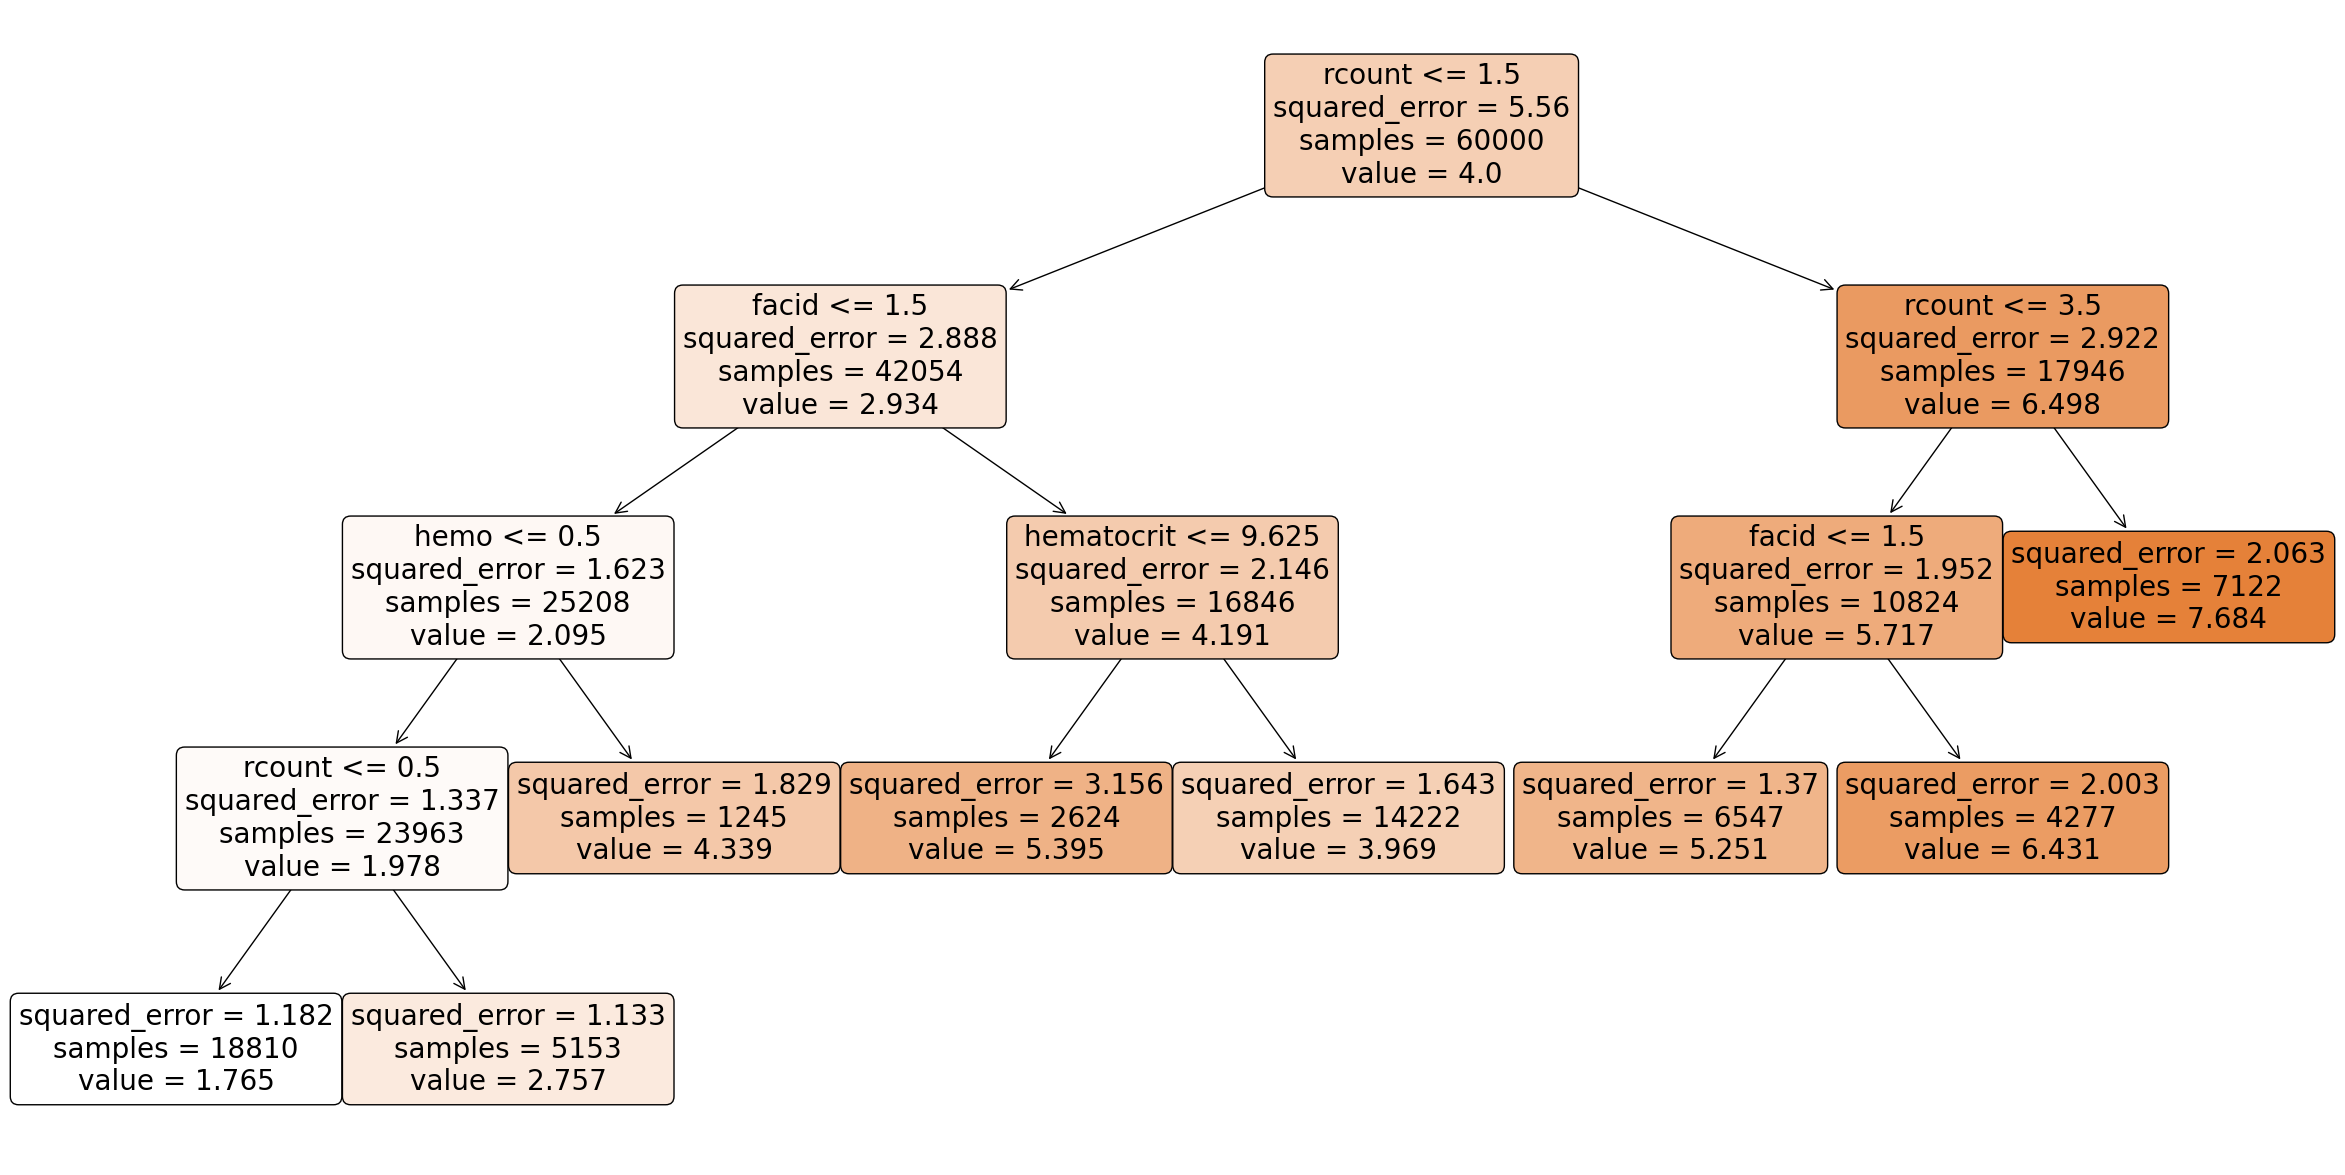

In [44]:
# Crea un albero decisionale per la regressione
tree = DecisionTreeRegressor(max_depth= 5, ccp_alpha=0.05, min_samples_split=4, random_state=0)
tree.fit(xtree_train, ytree_train)

#elenco_modelli.append(('TREE', tree))

# Crea una figura
plt.figure(figsize=(30,15))

# Disegna l'albero
plot_tree(tree, max_depth=5, filled=True, rounded=True, feature_names=features)

# Mostra il plot
plt.show()


### Definizione architettura Foresta

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

forest = RandomForestRegressor()

forest.set_params(n_estimators=70, max_depth=20)

forest.fit(x_train, y_train)

#elenco_modelli.append(('FOREST', forest))

RandomForestRegressor(max_depth=20, n_estimators=70)

### Definizione architettura Ensemble

In [46]:
# Importa i moduli necessari
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge

# Crea i modelli individuali
tree1 = DecisionTreeRegressor(max_depth=5, ccp_alpha=0.05, min_samples_split=4, random_state=0)
linear = LinearRegression()
bayes = BayesianRidge()

# Crea il modello di ensemble
ensemble = VotingRegressor(estimators=[('tree', tree1), ('linear', linear), ('bayes', bayes)])

# Allena il modello utilizzando i dati di addestramento
ensemble.fit(xtree_train, ytree_train)

#elenco_modelli.append(('ENSEMBLE', ensemble))


VotingRegressor(estimators=[('tree',
                             DecisionTreeRegressor(ccp_alpha=0.05, max_depth=5,
                                                   min_samples_split=4,
                                                   random_state=0)),
                            ('linear', LinearRegression()),
                            ('bayes', BayesianRidge())])

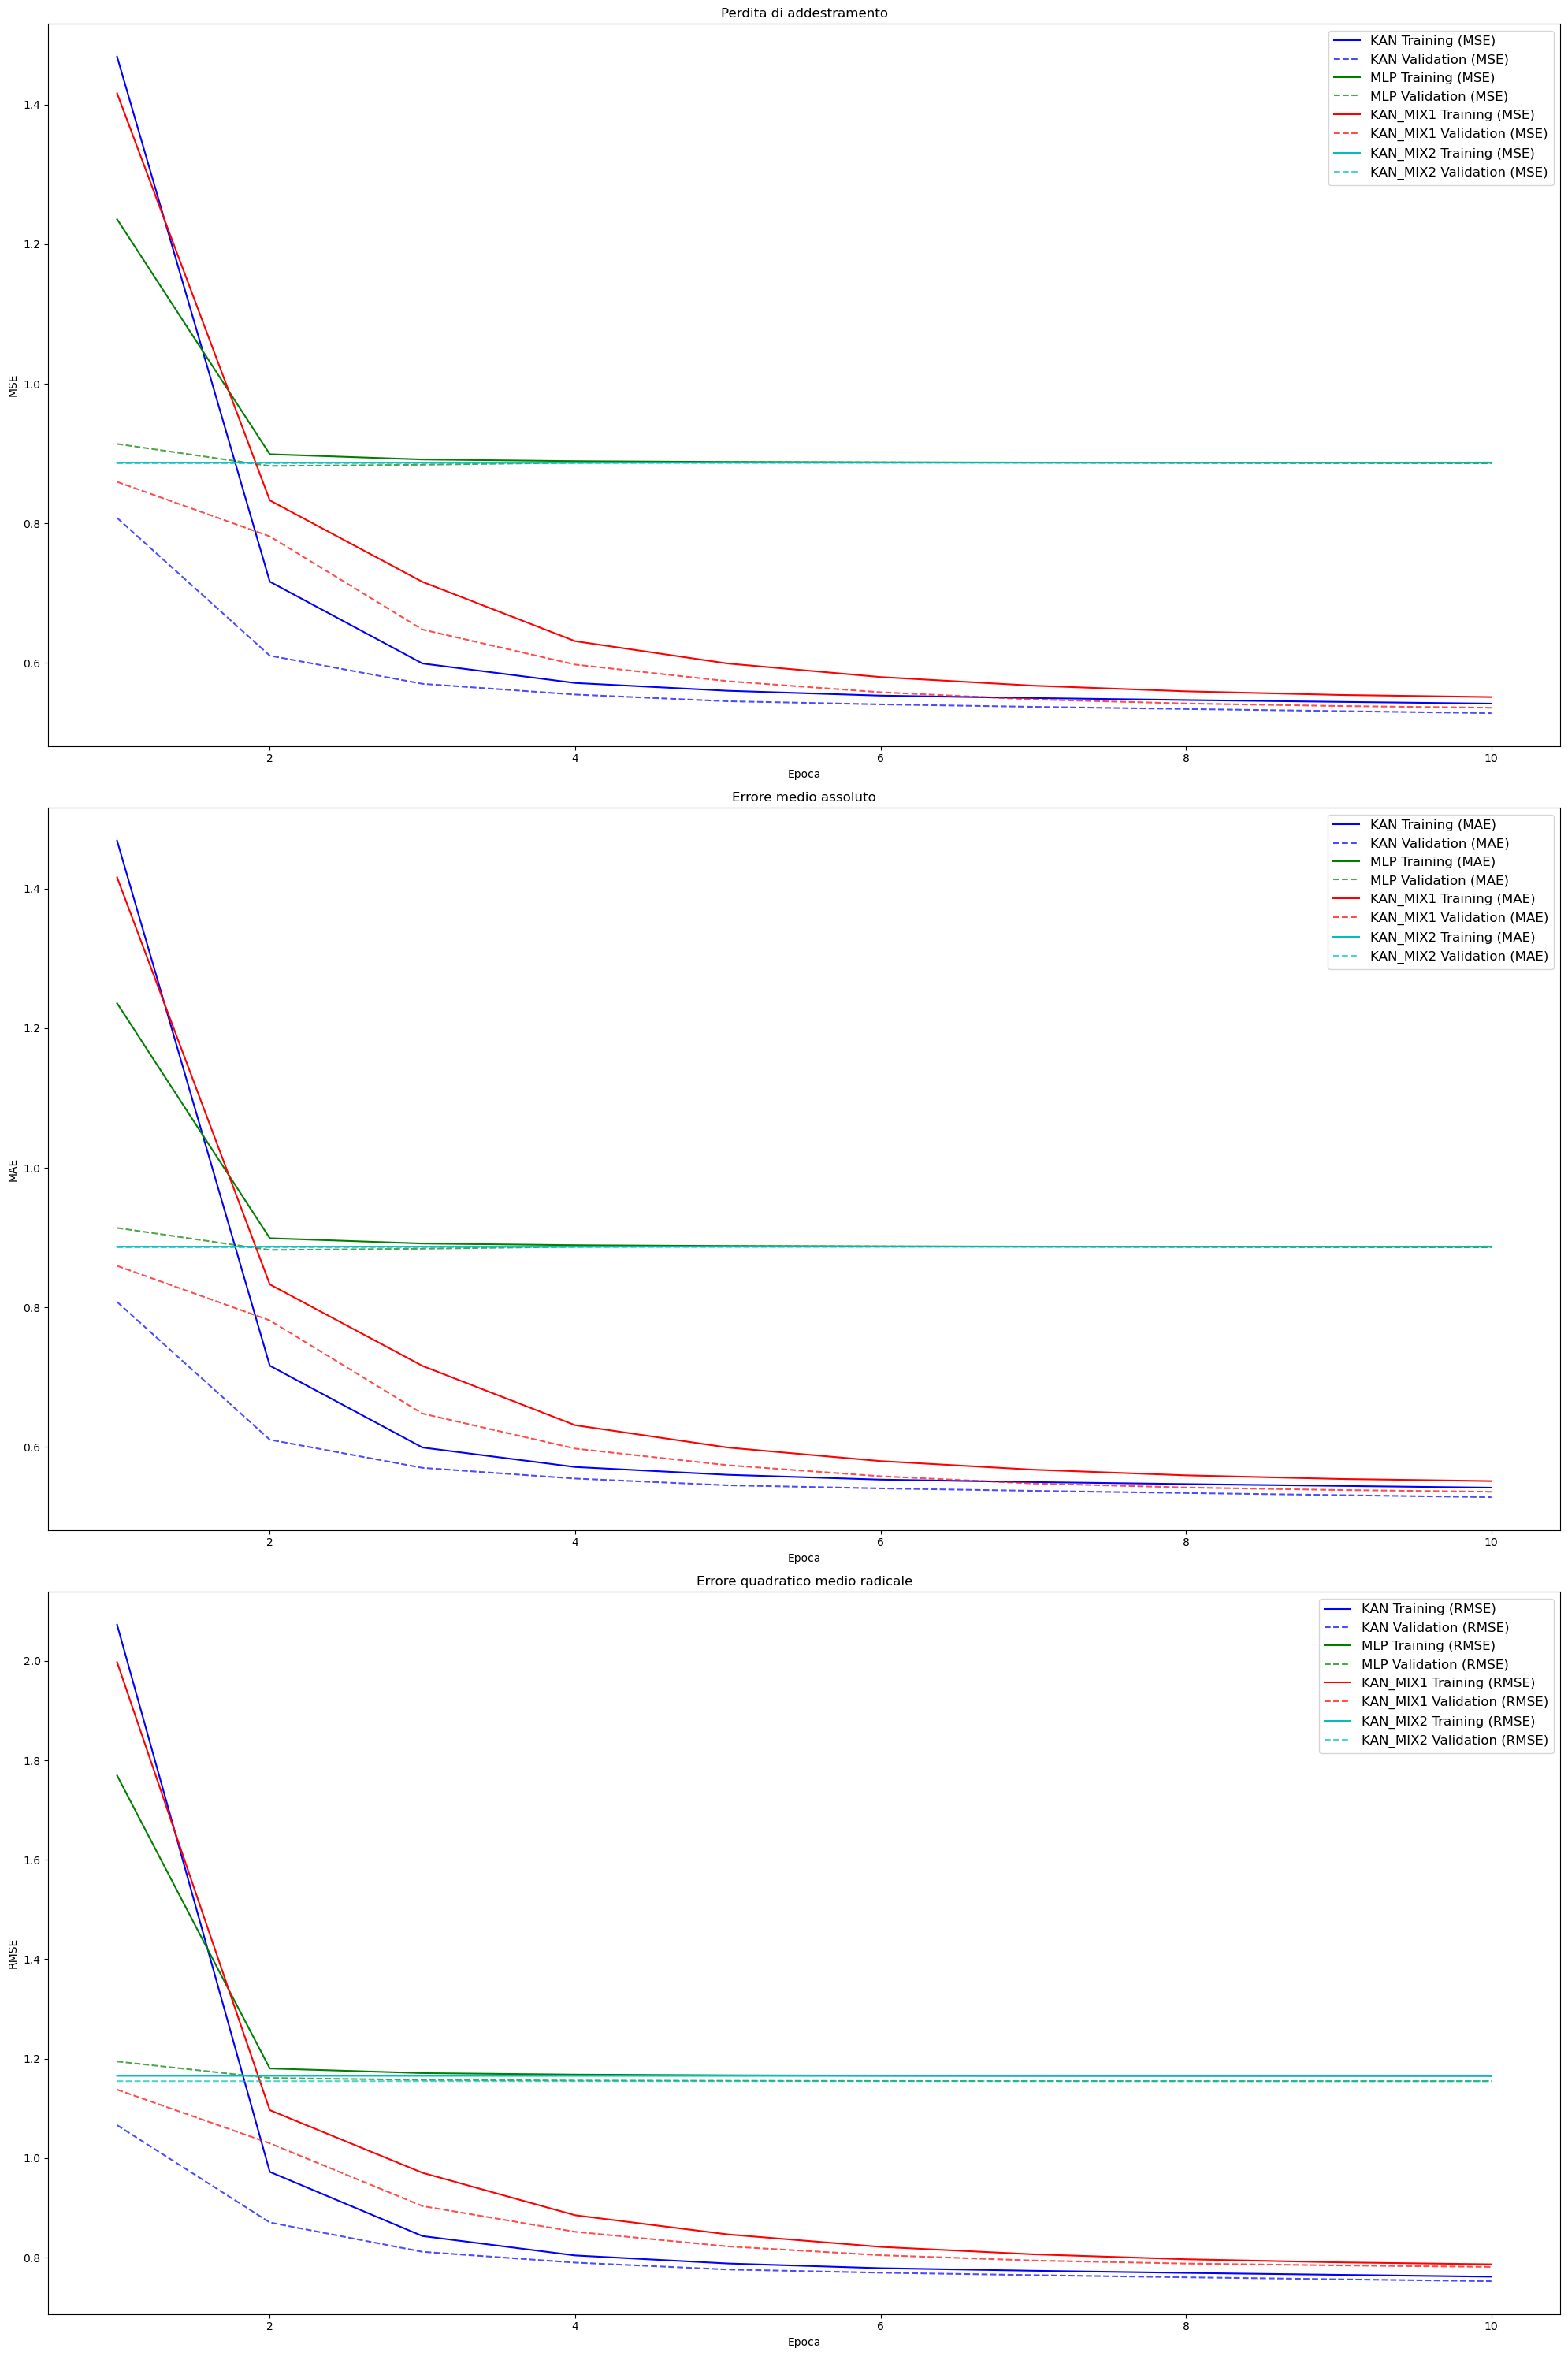

In [47]:
# Crea una lista di colori
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

plt.figure(figsize=(20, 30))

for i, (model_name, history) in enumerate(histories):
    loss = history.history['mae']
    val_loss = history.history['val_mae']
    mae = history.history['mae']
    val_mae = history.history['val_mae']
    rmse = history.history['rmse']
    val_rmse = history.history['val_rmse']

    epochs = range(1, len(loss) + 1)

    # Usa lo stesso colore per il training e il validation set di ogni modello
    color = colors[i % len(colors)]

    plt.subplot(3, 1, 1)
    plt.plot(epochs, loss, color, label=f'{model_name} Training (MSE)') 
    plt.plot(epochs, val_loss, color+'--', alpha=0.7, label=f'{model_name} Validation (MSE)') 
    plt.title('Perdita di addestramento')
    plt.xlabel('Epoca')
    plt.ylabel('MSE')
    plt.legend(fontsize='large')

    plt.subplot(3, 1, 2)
    plt.plot(epochs, mae, color, label=f'{model_name} Training (MAE)') 
    plt.plot(epochs, val_mae, color+'--', alpha=0.7, label=f'{model_name} Validation (MAE)') 
    plt.title('Errore medio assoluto')
    plt.xlabel('Epoca')
    plt.ylabel('MAE')
    plt.legend(fontsize='large')

    plt.subplot(3, 1, 3)
    plt.plot(epochs, rmse, color, label=f'{model_name} Training (RMSE)') 
    plt.plot(epochs, val_rmse, color+'--', alpha=0.7, label=f'{model_name} Validation (RMSE)') 
    plt.title('Errore quadratico medio radicale')
    plt.xlabel('Epoca')
    plt.ylabel('RMSE')
    plt.legend(fontsize='large')

plt.tight_layout()
plt.show()


274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step


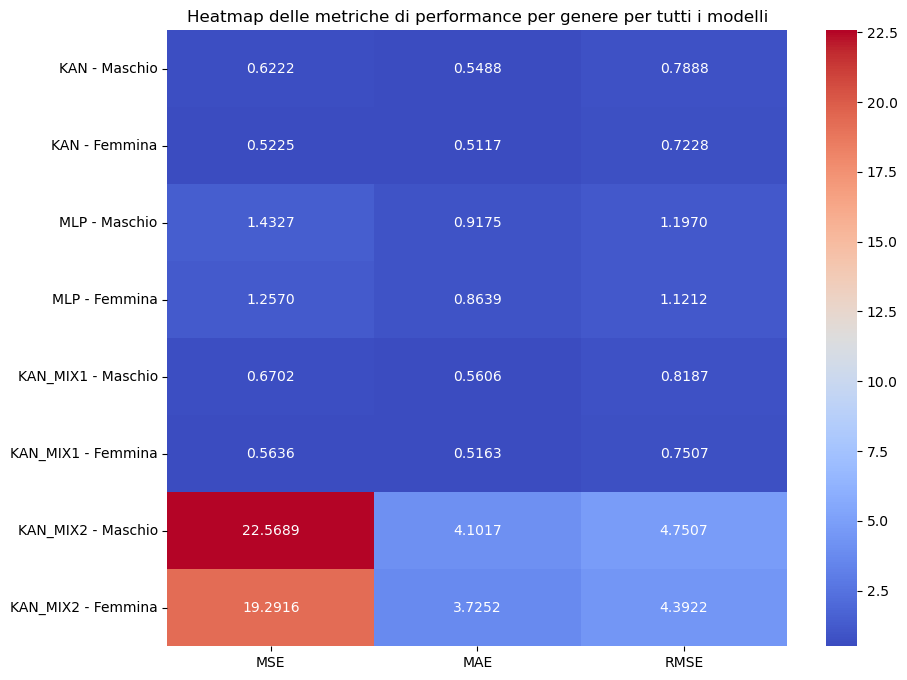

In [48]:
# Definizione delle categorie e sottogruppi
CATEGORY = 2  # indice dell'attributo "gender" nel tuo dataset
SUBGROUPS = [0, 1]  # 0 per maschio, 1 per femmina
# Creazione di un dizionario per memorizzare i risultati
all_results = {}

# Per ogni modello nella tua lista 'elenco_modelli'
for model_name, model in elenco_modelli:
    results = {}
    for sg in SUBGROUPS: #per ogni gruppo nell'elenco dei sottogruppi
        
        # Filtraggio del dataset di test per il sottogruppo corrente
        subgroup_indices = x_test[:, CATEGORY] == sg
        features = x_test[subgroup_indices]
        labels = y_test[subgroup_indices]
        
        # Calcolo delle previsioni del modello sul sottogruppo corrente
        predictions = model.predict(features)
        
        # Calcolo delle metriche personalizzate per ciascun sottogruppo
        mse_value = tf.keras.metrics.MeanSquaredError()(labels, predictions).numpy()
        mae_value = tf.keras.metrics.MeanAbsoluteError()(labels, predictions).numpy()
        rmse_value = np.sqrt(mse_value)
        
        # Memorizzazione dei risultati
        results[sg] = [mse_value, mae_value, rmse_value]

    # Aggiungi i risultati di questo modello ai risultati totali
    all_results[model_name] = results

# Creazione di un DataFrame per visualizzare le metriche di performance di tutti i modelli
df = pd.DataFrame()

for model_name, results in all_results.items():
    temp_df = pd.DataFrame(results, index=['MSE', 'MAE', 'RMSE'])
    temp_df.columns = [f'{model_name} - Maschio', f'{model_name} - Femmina']
    df = pd.concat([df, temp_df], axis=1)

# Conversione dei dati in float
df = df.astype(float)

# Trasposizione del DataFrame per invertire righe e colonne
df = df.transpose()

# Calcolo dei valori minimi e massimi per la scala di colori
vmin = df.min().min()
vmax = df.max().max()

# Creazione della heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt=".4f", vmin=vmin, vmax=vmax)
plt.title('Heatmap delle metriche di performance per genere per tutti i modelli')
plt.show()



In [49]:
features = [
    'vdate', 'rcount', 'gender', 'dialysis', 'asthma', 'irondef', 'pneum', 'subdep', 'psychmaj',
    'depress', 'psychother', 'fibrosis', 'malnutr', 'hemo', 'hematocrit', 'neutrophils', 'sodium',
    'glucose', 'bun', 'creatinine', 'bmi', 'pulse', 'respiration', 'secdiag', 'discharged', 'facid'
]


# Lista delle caratteristiche
def calculate_feature_importance(model, x_val, y_val):
    # Calcola l'importanza delle caratteristiche
    results = permutation_importance(model, x_val, y_val, scoring='neg_mean_squared_error')
    # Ottieni l'importanza delle caratteristiche
    importance = results.importances_mean
    # Crea un dizionario con le caratteristiche e la loro importanza
    feature_importance = dict(zip(features, importance))
    return feature_importance

caratteristiche = []
for nome, modello in elenco_modelli:
    caratteristiche.append((nome, calculate_feature_importance(modello, x_test, y_test)))

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
625/625 ━━━

In [50]:
def stampa_importanza_caratteristiche(caratteristiche):
    for nome_modello, importanza_caratteristiche in caratteristiche:
        print(f"Modello: {nome_modello}")
        totale = sum(importanza_caratteristiche.values())
        for caratteristica, importanza in importanza_caratteristiche.items():
            percentuale = (importanza / totale) * 100
            print(f"Caratteristica: {caratteristica}, Importanza: {percentuale:.2f}%")
        print("\n")

stampa_importanza_caratteristiche(caratteristiche)


Modello: KAN
Caratteristica: vdate, Importanza: 0.00%
Caratteristica: rcount, Importanza: 66.44%
Caratteristica: gender, Importanza: 0.01%
Caratteristica: dialysis, Importanza: 1.05%
Caratteristica: asthma, Importanza: 1.21%
Caratteristica: irondef, Importanza: 2.42%
Caratteristica: pneum, Importanza: 0.89%
Caratteristica: subdep, Importanza: 2.02%
Caratteristica: psychmaj, Importanza: 7.64%
Caratteristica: depress, Importanza: 0.98%
Caratteristica: psychother, Importanza: 1.26%
Caratteristica: fibrosis, Importanza: 0.20%
Caratteristica: malnutr, Importanza: 1.26%
Caratteristica: hemo, Importanza: 2.29%
Caratteristica: hematocrit, Importanza: 2.64%
Caratteristica: neutrophils, Importanza: 0.28%
Caratteristica: sodium, Importanza: 1.52%
Caratteristica: glucose, Importanza: 1.59%
Caratteristica: bun, Importanza: 0.25%
Caratteristica: creatinine, Importanza: 1.53%
Caratteristica: bmi, Importanza: 1.62%
Caratteristica: pulse, Importanza: 1.50%
Caratteristica: respiration, Importanza: 1.38%

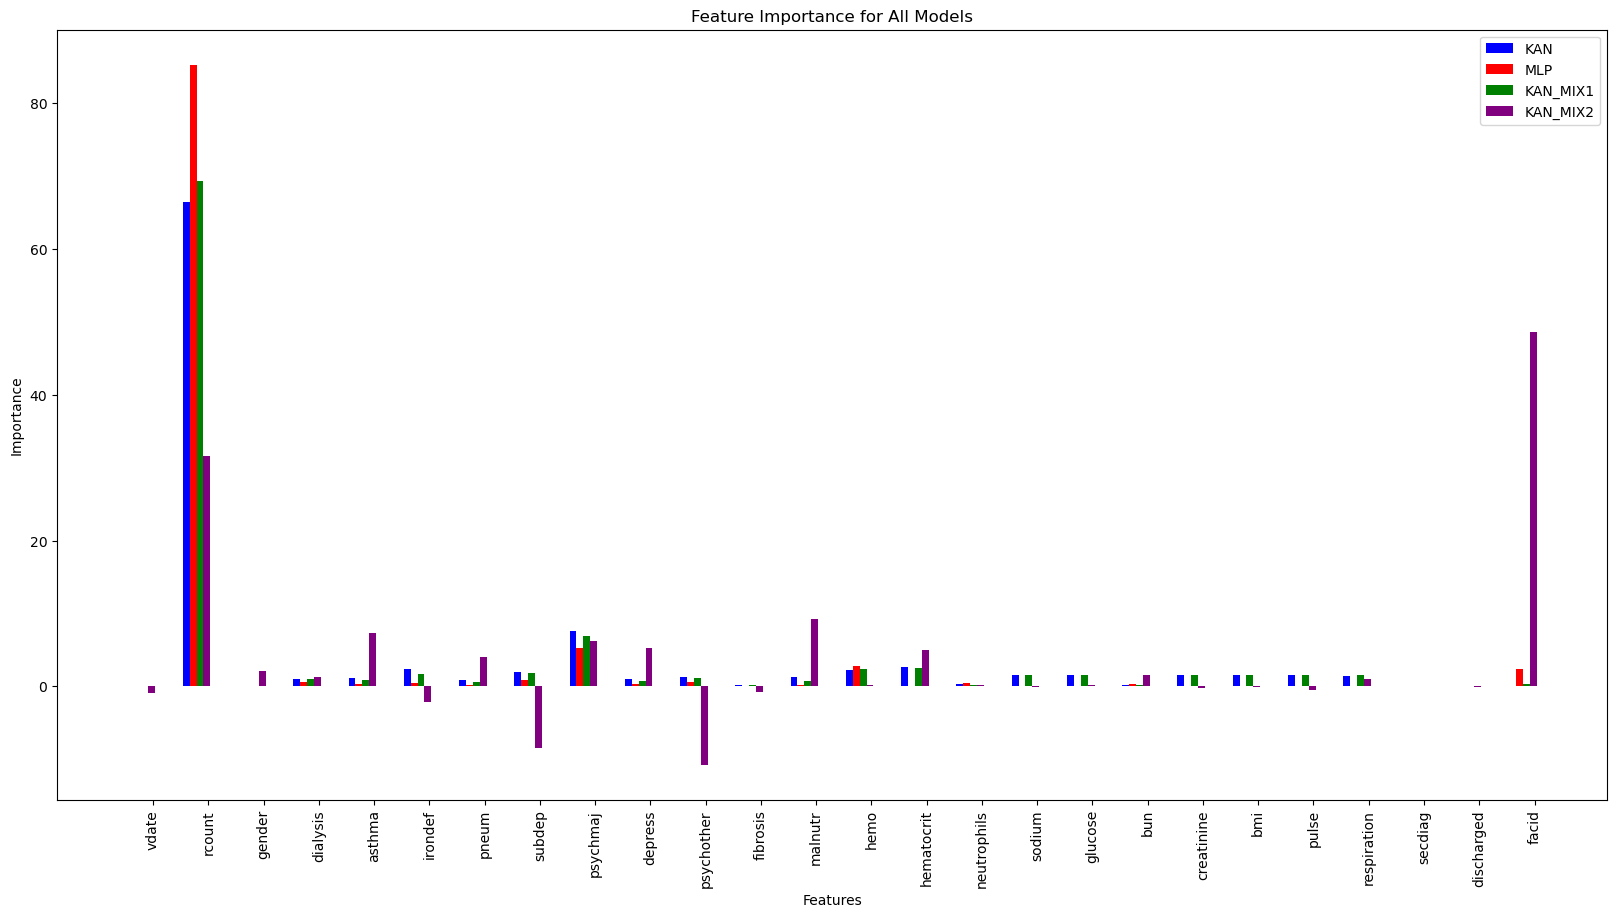

In [56]:
# Inizializza i contatori e i dizionari per l'importanza delle caratteristiche
contatori = {}
importanze = {}

# Calcola l'importanza delle caratteristiche per ogni modello
for nome, importanza in caratteristiche:
    contatori[nome] = 0
    importanze[nome] = {}
    for feature, importance in importanza.items():
        contatori[nome] += importance
        importanze[nome][feature] = importance

# Normalizza l'importanza delle caratteristiche per ogni modello
for nome in importanze.keys():
    for key in importanze[nome].keys():
        importanze[nome][key] = importanze[nome][key] / contatori[nome] * 100

# Crea le etichette per l'asse x
x = np.arange(len(importanze[nome].values()))

# Crea un grafico a barre con dimensioni personalizzate
fig, ax = plt.subplots(figsize=(20, 10))  # Modifica le dimensioni qui

# Calcola la larghezza delle barre in base al numero di modelli
bar_width = 0.5 / len(importanze)  # Aggiungi questa linea

# Crea le barre per l'importanza delle caratteristiche per ogni modello
colors = ['blue', 'red', 'green', 'purple', 'yellow', 'orange', 'grey']  
for i, (nome, importanza) in enumerate(importanze.items()):
    ax.bar(x - 0.4 + i * bar_width, list(importanza.values()), bar_width, label=nome, color=colors[i % len(colors)])

# Aggiungi le etichette, il titolo e la legenda
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Feature Importance for All Models')
ax.set_xticks(x)

# Definisci le etichette dell'asse x
features = list(importanze[nome].keys())  
ax.set_xticklabels(features, rotation=90)

ax.legend()

# Mostra il grafico
plt.show()


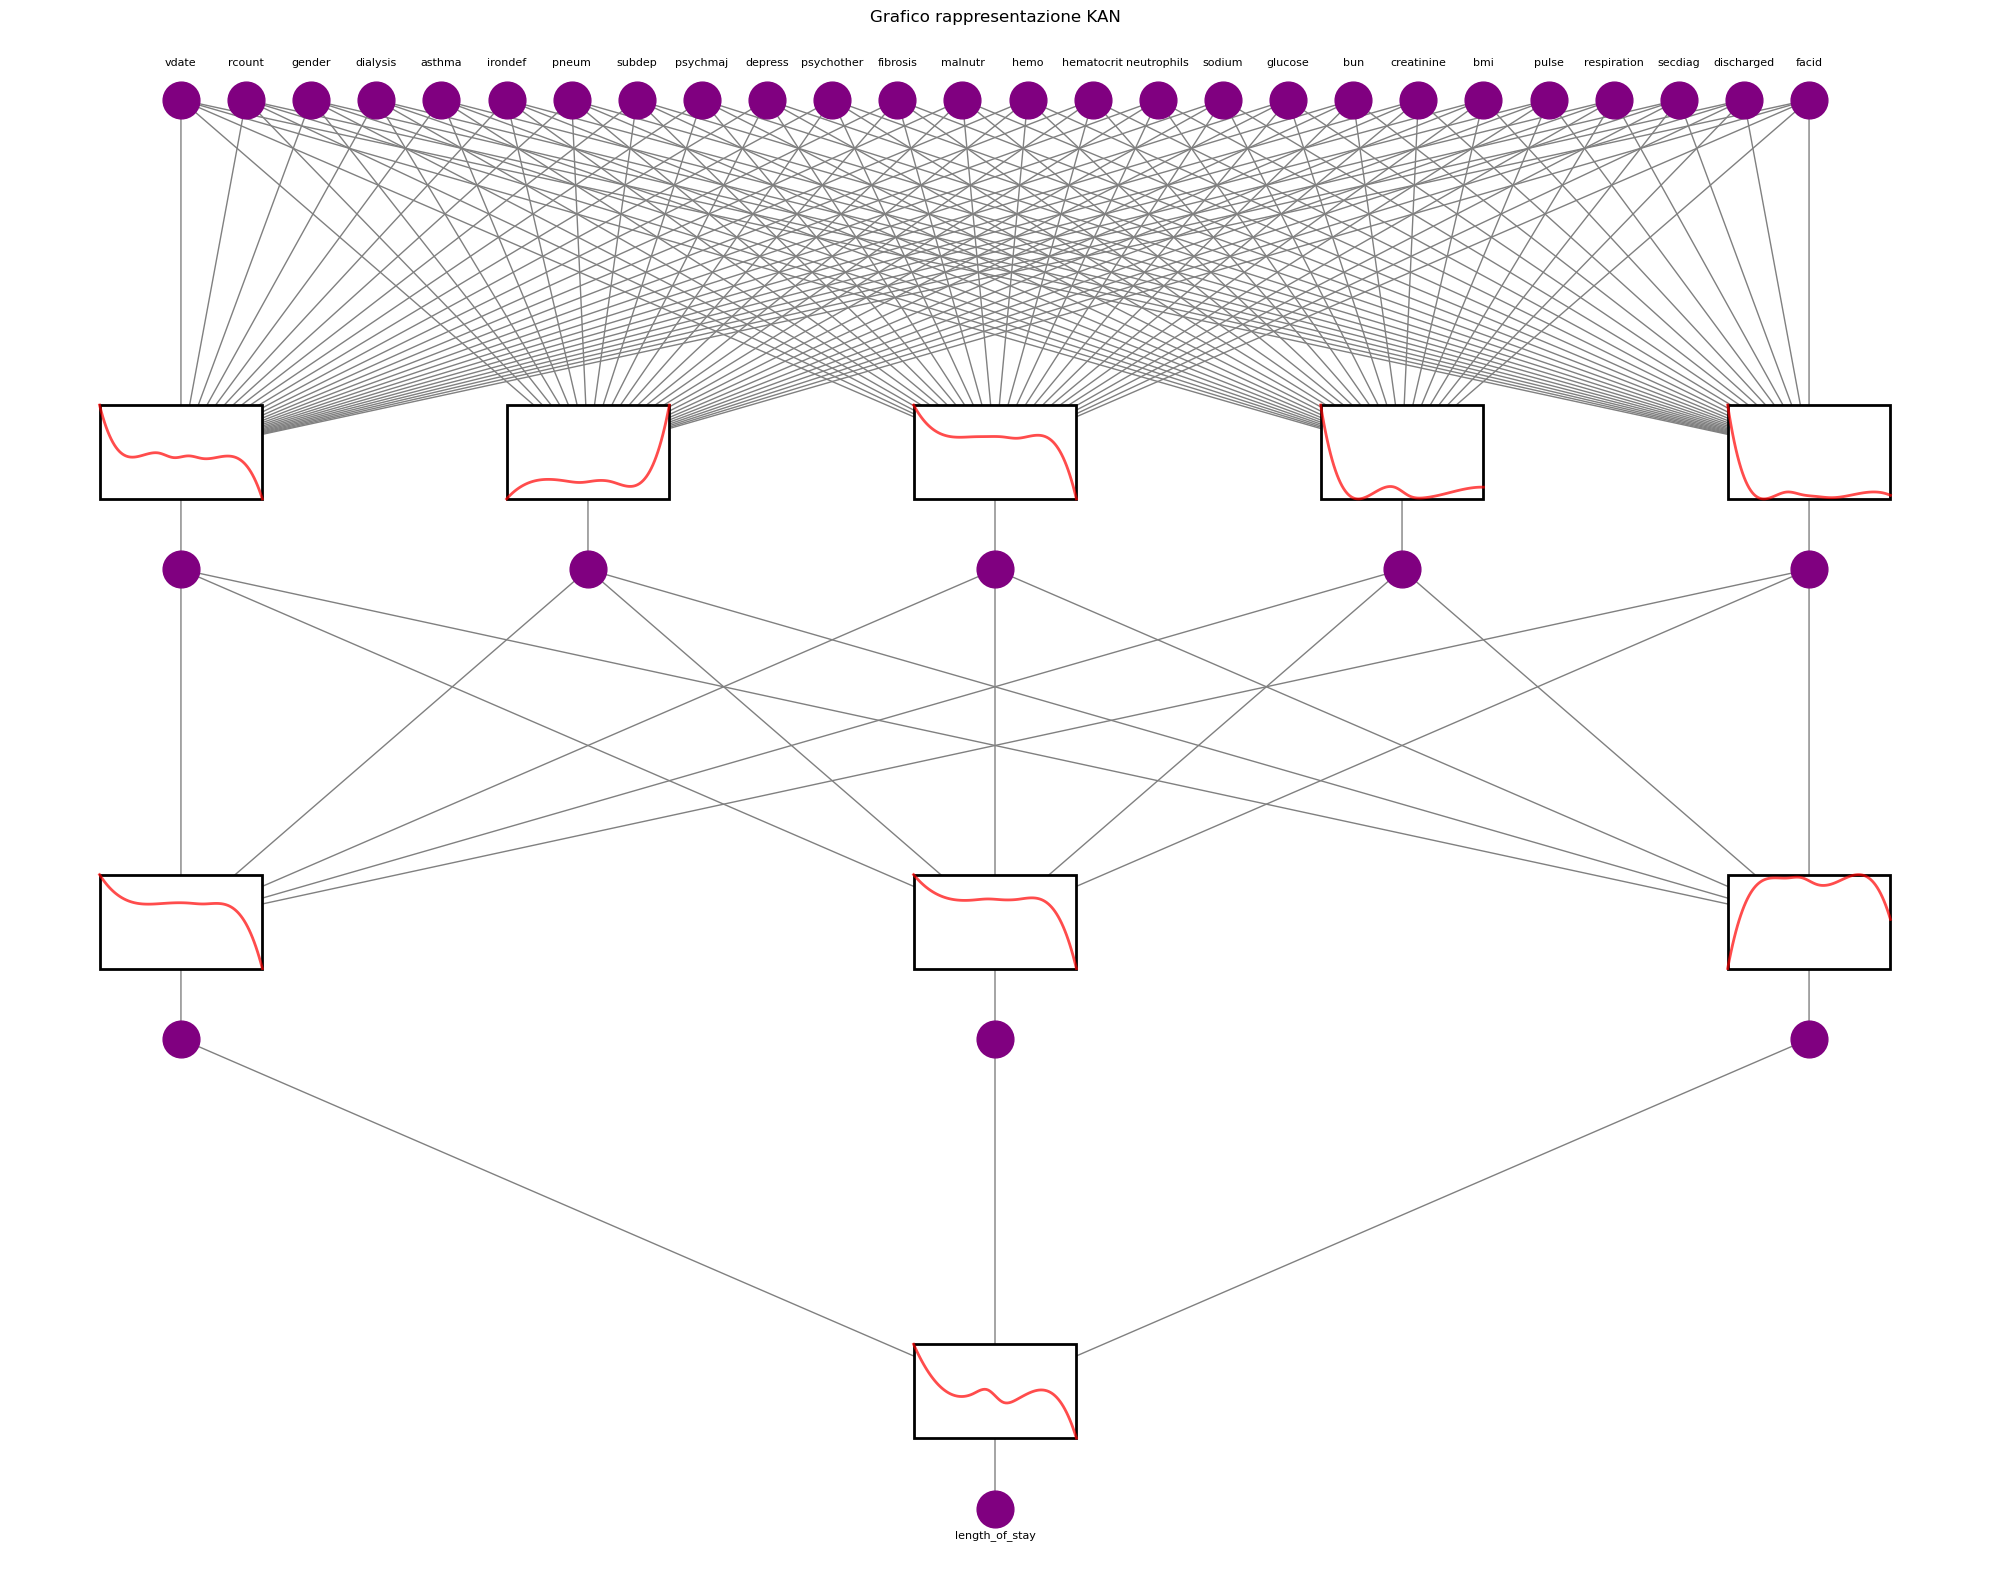

In [52]:
def get_all_splines_from_model(model):
    all_splines = []
    for layer in model.layers:
        if isinstance(layer, DenseKAN):
            all_splines.extend(layer.spline_list)
    return all_splines

def create_kan_tree_from_model(model, features):
    G = nx.DiGraph()
    
    # Add input nodes
    for i, feature in enumerate(features):
        G.add_node(feature, layer=0, pos=(i / (len(features) - 1) if len(features) > 1 else 0.5, 0))
    
    # Add hidden and output layers
    total_layers = len(model.layers)
    for layer_idx, layer in enumerate(model.layers):
        units = layer.units
        for j in range(units):
            x_pos = j / (units - 1) if units > 1 else 0.5
            G.add_node(f"h{layer_idx+1}_{j}", layer=layer_idx+1, pos=(x_pos, -(layer_idx+1) / (total_layers+1)))
        
        prev_layer_units = len(features) if layer_idx == 0 else model.layers[layer_idx-1].units
        for i in range(prev_layer_units):
            for j in range(units):
                if layer_idx == 0:
                    G.add_edge(features[i], f"h{layer_idx+1}_{j}")
                else:
                    G.add_edge(f"h{layer_idx}_{i}", f"h{layer_idx+1}_{j}")
    
    return G

def draw_merged_edges(G, pos, ax, kan, edge_color='gray'):
    merge_points = []
    for target in G.nodes():
        in_edges = list(G.in_edges(target))
        if len(in_edges) > 1:
            target_pos = np.array(pos[target])
            merge_point = target_pos + np.array([0, (pos[in_edges[0][0]][1] - target_pos[1]) / 4])
            merge_points.append(merge_point)
            
            for source, _ in in_edges:
                start = np.array(pos[source])
                ax.annotate("", xy=merge_point, xytext=start, arrowprops=dict(arrowstyle="-", color=edge_color, connectionstyle="arc3,rad=0.0"), zorder=1)
            
            ax.annotate("", xy=target_pos, xytext=merge_point, arrowprops=dict(arrowstyle="-", color=edge_color), zorder=1)
    
    spline_collection = get_all_splines_from_model(kan)
    square_size = 0.1  # Fixed square size
    for i, point in enumerate(merge_points):
        if i < len(spline_collection):
            square = plt.Rectangle((point[0] - square_size/2, point[1] - square_size/4), square_size, square_size / 2, fill=True, facecolor='white', edgecolor='black', linewidth=2, zorder=2)
            ax.add_patch(square)
            
            # Draw B-spline within the square
            spl = spline_collection[i]
            xx = np.linspace(spl.t[0], spl.t[-1], 100)
            yy = spl(xx)
            
            # Normalize B-spline values to fit the square
            xx_norm = (xx - np.min(xx)) / (np.max(xx) - np.min(xx)) * square_size + (point[0] - square_size/2)
            yy_norm = (yy - np.min(yy)) / (np.max(yy) - np.min(yy)) * (square_size / 2) + (point[1] - square_size / 4)
            
            ax.plot(xx_norm, yy_norm, color='#FF0000', lw=2, alpha=0.7, zorder=3)
    
    return merge_points

# Create graph from model
G = create_kan_tree_from_model(kan, features)

# Setup plot
fig, ax = plt.subplots(figsize=(20, 16))
pos = nx.get_node_attributes(G, 'pos')

# Draw edges and squares with B-splines
merge_points = draw_merged_edges(G, pos, ax, kan)

# Draw nodes
node_collection = nx.draw_networkx_nodes(G, pos, node_size=700, node_color='purple', ax=ax)
node_collection.set_zorder(4)  # Set zorder for nodes

# Add labels
label_pos = {node: (x, y + 0.02) for node, (x, y) in pos.items()}
labels = {node: node if G.nodes[node]['layer'] == 0 else "" for node in G.nodes()}
label_collection = nx.draw_networkx_labels(G, label_pos, labels, font_size=8, ax=ax)

# Add "length_of_stay" label below the lowest node
lowest_node = min(pos.items(), key=lambda x: x[1][1])[0]
ax.text(pos[lowest_node][0], pos[lowest_node][1] - 0.015, "length_of_stay", fontsize=8, ha='center')

plt.title("Grafico rappresentazione KAN")
plt.axis('off')
plt.tight_layout()
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step


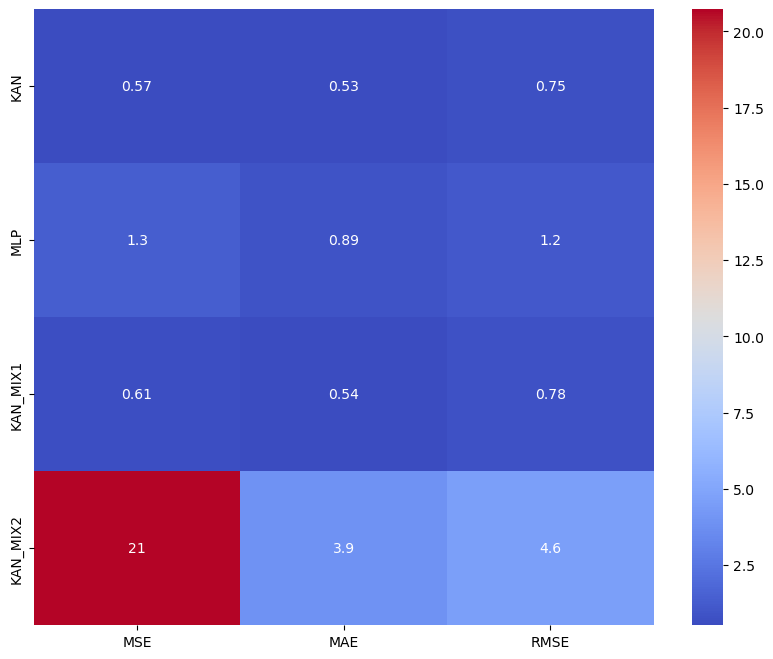

In [53]:

def calculate_metrics(model, X, y):
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    mae = mean_absolute_error(y, predictions)
    rmse = root_mean_squared_error(y, predictions)
    return mse, mae, rmse

def performance_heatmap(models, X, y):
    metrics = ['MSE', 'MAE', 'RMSE']
    performance = {metric: [] for metric in metrics}
    model_names = []

    for model_name, model in models:
        mse, mae, rmse = calculate_metrics(model, X, y)
        performance['MSE'].append(mse)
        performance['MAE'].append(mae)
        performance['RMSE'].append(rmse)
        model_names.append(model_name)

    df = pd.DataFrame(performance, index=model_names)
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, cmap='coolwarm')
    plt.show()

performance_heatmap(elenco_modelli, x_test, y_test)
